In [13]:
# TCC: 
# Code: 
# Author: Anísio Pereira Batista Filho

## Importações

In [15]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import string
import unicodedata

from cogroo4py.cogroo import Cogroo
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from tqdm import tqdm
from unidecode import unidecode
from wordcloud import WordCloud

## Abertura de arquivos e criação de dataframes:

In [ ]:
df = pd.read_csv('data/corpus_labeled/iguais/rotulacao_uniao[iguais].csv', sep=',', low_memory=True)

In [ ]:
df_internet = pd.read_csv('data/utils/abreviações_internet.csv', low_memory=True)

In [ ]:
df_estados = pd.read_csv('data/utils/abreviações_estados.csv', low_memory=True)

In [ ]:
df_vacinar = pd.read_csv('data/utils/flexões_vacinar.csv', low_memory=True)

In [ ]:
df_stopwords = pd.read_csv('data/utils/stopwords_internet_symboless.csv', low_memory=True)

In [ ]:
dict_internet = df_internet.set_index('sigla')['significado'].to_dict()

In [ ]:
dict_estados = df_estados.set_index('sigla')['estado'].to_dict()

In [ ]:
covidReplace = [ 'covid', 'covid-19', 'covid19', 'coronavirus', 'corona', 'virus' ]

In [ ]:
vacinaReplace = [
                    'coronavac', 'astrazeneca', 'pfizer', 
                    'sputnik v', 'sputnik', 'sinovac', 
                    'oxford', 'moderna', 'butantan', 
                    'johnson', 'johnson&johnson', 'jnj', 
                    'fio cruz', 'fiocruz' 
                ]

## Funções

### Inicializações

In [ ]:
cogroo = Cogroo()

In [ ]:
stopWords = nltk.corpus.stopwords.words('portuguese')

In [ ]:
spell = SpellChecker(language='pt')

In [ ]:
tqdm.pandas()

In [ ]:
stemmer = nltk.stem.RSLPStemmer()

In [ ]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={'hashtag', 'allcaps', 'elongated', 'repeated',
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter='twitter', 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector='twitter', 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

C:\Users\anisi\.conda\envs\tcc310\lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


C:\Users\anisi\.conda\envs\tcc310\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


### Realizador de pré-processamento

In [ ]:
def realiza_preproc(linha):
    ### Convertendo para string
    linha = str(linha)
    ### Removendo os '\n'
    linha = linha.replace('\n', ' ')
    ### Colocando as palavras em caixa baixa
    linha = linha.lower()
    ### Aplicando a correção gramatical do Spellchecker
    linha = spell.correction(linha)
    ### Aplicando o pre processamento do Ekprhasis
    linha = ' '.join(text_processor.pre_process_doc(linha))
    ### Removendo a pontuação da string
    linha = linha.translate(str.maketrans('', '', string.punctuation))
    ### Removendo a acentuação da string
    linha = unidecode(linha)
    ### Removendo espaços múltiplos
    linha = re.sub(r'\s+', ' ', linha)
    
    return linha

### Tokenizador NLTK

In [ ]:
def tokenizador_nltk(linha):
    linha = word_tokenize(linha, language='portuguese')
    return linha

### Removedor de stopwords NLTK

In [ ]:
##Remoção de Stopwords utilizando NLTK:
def remove_stopwords_nltk(linha):
    nova_linha = []
    for parte in linha:
        if parte not in stopWords:
            nova_linha.append(parte)
        
    return nova_linha

### Removedor de stopwords da internet

In [ ]:
def remove_stopwords_internet(linha):
    nova_linha = []
    for palavra in linha:
        if palavra not in df_stopwords.stopwords.to_list():
            nova_linha.append(palavra)
    
    return nova_linha

### Trocador de palavras

In [ ]:
def troca_palavras(linha):
    nova_linha = []
    for palavra in linha:
        if palavra in dict_internet.keys():
            palavra = palavra.replace(palavra, dict_internet[palavra])
        if palavra in dict_estados.keys():
            palavra = palavra.replace(palavra, dict_estados[palavra])
        if palavra in df_vacinar.flexao.to_list():
            palavra = palavra.replace(palavra, 'vacina')
        if palavra in covidReplace:
            palavra = palavra.replace(palavra, 'covid')            
        if palavra in vacinaReplace:
            palavra = palavra.replace(palavra, 'vacina')
        nova_linha.append(palavra)

    return nova_linha

### Aplicador do stemming NLTK

In [ ]:
def stemming_nltk(linha):
    nova_linha = []
    for palavra in linha:
        nova_linha.append(stemmer.stem(palavra))

    return nova_linha

### Aplicador do lemmatization Cogroo4py

In [ ]:
def lemmatization_cogroo4py(linha):
    nova_linha = []
    for palavra in linha:
        nova_linha.append(cogroo.lemmatize(palavra))

    return nova_linha

### Contador de frequência de palavras:

In [ ]:
def gera_frequencia_palavras(dicionario_frequencia, dataframe, coluna):
    for index, row in tqdm(dataframe.iterrows()):
        for palavra in row[coluna]:
            if palavra not in dicionario_frequencia.keys():
                dicionario_frequencia[palavra] = 1
            else:
                dicionario_frequencia[palavra] += 1
    
    dicionario_frequencia = dict(sorted(dicionario_frequencia.items(), key=lambda item: item[1]))
    
    return dicionario_frequencia

### Gerador de nuvem de palavras

In [ ]:
def gera_nuvem_palavras(dicionario_frequencia):
    wordcloud = WordCloud(#font_path=None, 
                        width=800, 
                        height=400, 
                        margin=2, 
                        ranks_only=None, 
                        prefer_horizontal=0.9, 
                        mask=None, 
                        scale=1, 
                        color_func=None, 
                        max_words=500, 
                        min_font_size=4, 
                        stopwords=None, 
                        random_state=None, 
                        background_color='white', 
                        max_font_size=None, 
                        font_step=1, 
                        mode='RGB', 
                        relative_scaling='auto', 
                        regexp=None, 
                        collocations=True, 
                        colormap='hsv', 
                        normalize_plurals=True, 
                        contour_width=0, 
                        contour_color='black', 
                        repeat=False, 
                        include_numbers=False, 
                        min_word_length=0, 
                        collocation_threshold=30).generate_from_frequencies(dicionario_frequencia)
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax.imshow(wordcloud, interpolation='bilinear')       
    ax.set_axis_off()
    
    return fig, wordcloud

## Main

### Pré-processamento da coluna tweet_text

In [ ]:
df['tweet_text_preproc'] = df.tweet_text.progress_map(realiza_preproc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [30:37<00:00,  1.96it/s]


In [ ]:
df['tweet_text_preproc'] = df.tweet_text_preproc.progress_map(tokenizador_nltk)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:01<00:00, 2464.85it/s]


In [ ]:
df['tweet_text_preproc'] = df.tweet_text_preproc.progress_map(remove_stopwords_nltk)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:00<00:00, 7688.98it/s]


In [ ]:
df['tweet_text_preproc'] = df.tweet_text_preproc.progress_map(remove_stopwords_internet)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:01<00:00, 1824.63it/s]


In [ ]:
df['tweet_text_preproc'] = df.tweet_text_preproc.progress_map(troca_palavras)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:01<00:00, 3057.97it/s]


### Criação da coluna com o stemming aplicado

In [ ]:
df['tweet_text_stemming'] = df.tweet_text_preproc.progress_map(stemming_nltk)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:05<00:00, 710.04it/s]


### Criação da coluna com o lemmatization aplicado

In [ ]:
df['tweet_text_lemmatization'] = df.tweet_text_preproc.progress_map(lemmatization_cogroo4py)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:12<00:00, 278.70it/s]


### Visualização da base após as etapas anteriores

In [ ]:
df[['tweet_text', 'tweet_text_preproc', 'tweet_text_stemming', 'tweet_text_lemmatization']]

,tweet_text,tweet_text_preproc,tweet_text_stemming,tweet_text_lemmatization
0,@HugoMachadoFil3 @quadrelli_marco A parceria c...,"[parceria, chineses, vacina, preve, troca, con...","[parc, chines, vacin, prev, troc, conhec, tecn...","[parceria, chinês, vacina, preve, troca, conhe..."
1,@danielgirardi83 @Fenovais28 @mab_sp125 @samyd...,"[por que, deixa, minion, nervoso, juro, incomp...","[por qu, deix, minion, nerv, jur, incompet, pr...","[por que, deixar, minion, nervoso, juro, incom..."
2,@edisonrd1977 Es peligrosa la vacuna de Pfizer?,"[espirito santo, peligrosa, la, vacuna, vacina]","[espirito sant, peligr, la, vacun, vacin]","[espirito santo, peligrosa, lo, vacuna, vacina]"
3,@MBittencourtMD @samydana @GabrielNemer_ @mab_...,"[entao, perdi, aqui, grupo, placebo, pegaram, ...","[enta, perd, aqu, grup, placeb, peg, covid, gr...","[entao, perder, aqui, grupo, placebo, pegar, c..."
4,"Vidas importam! Sim, vidas importam. Mas tamb...","[vidas, importam, sim, vidas, importam, recebe...","[vid, import, sim, vid, import, receb, vacin, ...","[vida, importar, sim, vida, importar, receber,..."
...,...,...,...,...
3595,@greenparadyse @gsilvaflavio @CNNBrasil Você s...,"[leu, manchete, vacina, informar, sobre, envio...","[leu, manchet, vacin, inform, sobr, envi, docu...","[ler, manchete, vacina, informar, sobre, envia..."
3596,"@GugaNoblat Q dó, ver um esquerdinha grudado n...","[ver, esquerdinha, grudado, bolas, doria, vaci...","[ver, esquerd, grud, bol, dor, vacin, cheg]","[ver, esquerdinha, grudar, bola, doria, vacina..."
3597,@da_cia @victormasc Não tenho nada a ver com n...,"[nada, ver, nada, disso, sequer, votei, psdb, ...","[nad, ver, nad, diss, sequ, vot, psdb, anvis, ...","[nada, ver, nada, de isso, sequer, votar, psdb..."
3598,"@djivanrodrigues @VEJA Sim, mas antes ele sina...","[sim, antes, sinalizou, apenas, milhoes, vacin...","[sim, ant, sinaliz, apen, milho, vacin, aprese...","[sim, antes, sinalizar, apenas, milhoes, vacin..."


### Geração da nuvem de palavras para a coluna tweet_text_stemming

In [ ]:
stemming_dict = dict()
stemming_dict = gera_frequencia_palavras(stemming_dict, df, 'tweet_text_stemming')

3600it [00:00, 12005.93it/s]


C:\Users\anisi\AppData\Local\Temp\ipykernel_9268\847384145.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  stemming_fig.show()


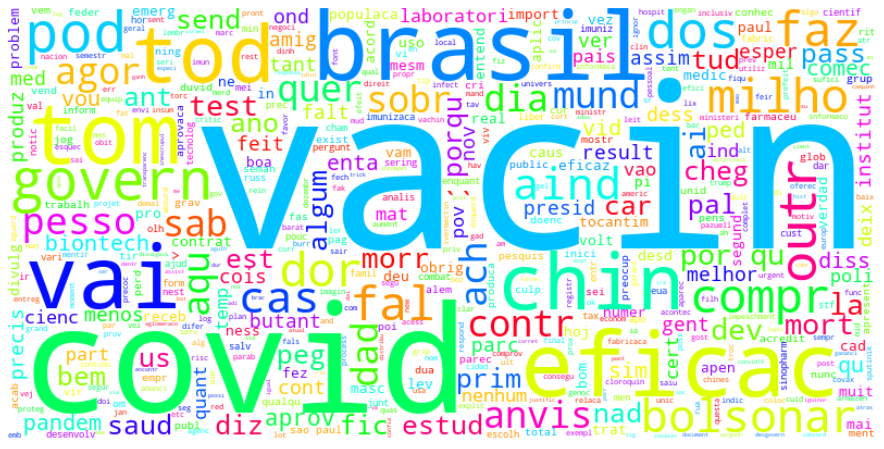

In [ ]:
stemming_fig, stemming_wordcloud = gera_nuvem_palavras(stemming_dict)
#stemming_wordcloud.to_file('wordcloud/corpus_labeled/iguais/wordcloud_tcc/02_text_preprocessing_-_tweet_text_stemming.png')
stemming_fig.show()

### Geração da nuvem de palavras para a coluna tweet_text_lemmatization

In [ ]:
lemmatization_dict = dict()
lemmatization_dict = gera_frequencia_palavras(stemming_dict, df, 'tweet_text_lemmatization')

3600it [00:00, 11955.32it/s]


C:\Users\anisi\AppData\Local\Temp\ipykernel_9268\369761565.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  lemmatization_fig.show()


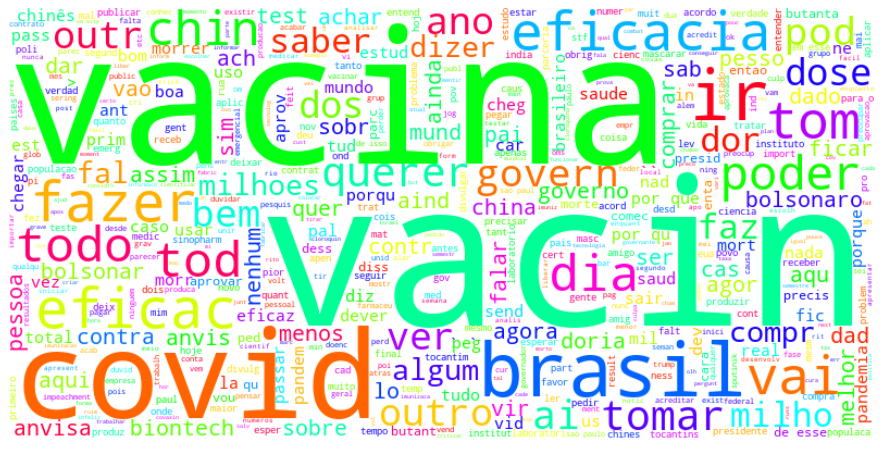

In [ ]:
lemmatization_fig, lemmatization_wordcloud = gera_nuvem_palavras(lemmatization_dict)
#lemmatization_wordcloud.to_file('wordcloud/corpus_labeled/iguais/wordcloud_tcc/02_text_preprocessing_-_tweet_text_lemmatization.png')
lemmatization_fig.show()

### Salvando a base gerada

In [ ]:
df.to_csv('data/corpus_labeled/iguais/bases_tcc/02_text_preprocessing_base.csv', sep=',', index=False)